In [ ]:
import numpy as np
import random
from time import sleep
from tqdm import tqdm
from scipy import linalg as LA
from matplotlib import pyplot as plt 
from scipy.stats import mstats

random.seed(10)
colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]

In [ ]:

def excl_max(arr,indices):
    mask = np.zeros(arr.size, dtype=bool)
    mask[indices] = True
    a = np.ma.array(arr, mask=mask)
    return np.max(a)

In [ ]:
T = 50000
K = 4
niter = 1
sampling_rules = ["UCB","SI-EXP3","S-EXP3"]

regret = np.zeros((2,niter,T))

for iter in tqdm(range(niter)):
    L1=np.zeros((K,K))
    L2=np.zeros((K,K))
    n1=np.zeros(K)
    z1=np.zeros(K)
    n2=np.zeros(K)
    z2=np.zeros(K)

    cum_loss =np.zeros(K)

    theta = np.array([1,2,3,10])#np.random.uniform(low=0.1,high=0.9,size=K)
    print(theta)
    pref=np.zeros((K,K))
    for i in range(K):
        for j in range(K):
            pref[i][j]=theta[i]/(theta[i]+theta[j])


    lossa1=np.zeros(K)
    lossa2=np.zeros(K)
    #lossb1=np.zeros(K)
    #lossb2=np.zeros(K)

    for t in range(T):


        eta = 1/(t+1)**0.5
        lam = 1/np.sqrt(t+1)

        avail=np.ones(K,dtype=int)
        
        choicea1 = ucb(n1, z1, t, avail)
        #choiceb1, L1 = SIEXP3(L1, eta, avail, lossb1)

        
        avail_moda=avail
        #avail_modb=avail
        avail_moda[choicea1]=0
        #avail_modb[choiceb1]=0

        
        choicea2 = ucb(n2, z2, t, avail_moda)
        #choicea2=0 #np.random.randint(0,K)
        #while choicea2==choicea1:
        #    choicea2=np.random.randint(0,K)
        #choiceb2, L2 = SIEXP3(L2, eta, avail_modb, lossb2)

        lossa1=np.random.binomial(n=1,p=pref[choicea2],size=K)
        lossa2=np.random.binomial(n=1,p=pref[choicea1],size=K)

        #print(pref[choicea2])
        cum_loss+=lossa1
        n1,z1=ucb_update(n1,z1,lossa1,choicea1)
        n2,z2=ucb_update(n2,z2,lossa2,choicea2)

        #lossb1=np.random.binomial(n=1,p=pref[choiceb2][0],size=K)
        #lossb1=np.multiply(lossb1,avail)
        #lossb2=np.random.binomial(n=1,p=pref[choiceb1][0],size=K)
        #lossb2=np.multiply(lossb2,avail_modb)

        choicea1=[choicea1]
        choicea2=[choicea2]
        
        #print(theta,n1/t,choicea1)
        #oracle_choice = np.argmax(theta)
        #regret[0,iter,t] = lossa1[choicea1]-lossa1[oracle_choice]

        regret[0,iter,t]=(excl_max(np.squeeze(pref[:,choicea1],1),choicea1)+excl_max(np.squeeze(pref[:,choicea2],1),choicea2)-1)/2.0
        #regret[1,iter,t]=(excl_max(np.squeeze(pref[:,choiceb1],1),choiceb1)+excl_max(np.squeeze(pref[:,choiceb2],1),choiceb2)-1)/2.0

    #times=np.arange(T)
    print(cum_loss/T)
    regret[0,iter,:]=np.cumsum(regret[0,iter,:])#/times
    #regret[1,iter,:]=np.cumsum(regret[1,iter,:])


In [ ]:
T_plot = T
fig=plt.figure(figsize=(4,3), dpi= 100, facecolor='w', edgecolor='k')  # to have big plots
for i in range(1):
    means = np.mean(regret[i,:,:], axis=0)
    quantiles = mstats.mquantiles(regret[i,:,:], axis=0)
    plt.plot(np.arange(T_plot-1),means[1:T_plot], label=sampling_rules[i], color = colors[i+1], linewidth=2)
    plt.fill_between(np.arange(T_plot-1), quantiles[0,1:T_plot] ,quantiles[2,1:T_plot], color= colors[i+1], alpha=.2)
plt.xlabel("Time")
plt.ylabel('Regret')
plt.legend()
plt.savefig('exp1.pdf', bbox_inches = "tight")
plt.show()

In [ ]:
T = 1000
K = 3
niter = 1
sampling_rules = ["UCB","SI-EXP3","S-EXP3"]

regret = np.zeros((niter,T))

for iter in tqdm(range(niter)):
    
    sleep=np.random.uniform(low=0.3,high=0.9,size=K)
    L1=np.zeros((K,K))
    L2=np.zeros((K,K))

    cum_loss =np.zeros(K)

    theta = np.random.uniform(low=0.1,high=0.9,size=K)
    pref=np.zeros((K,K))
    for i in range(K):
        for j in range(K):
            pref[i][j]=theta[i]/(theta[i]+theta[j])


    for t in range(T):
        #loss=1-np.array(range(K),float)/K
        loss1=np.zeros(K)
        loss2=np.zeros(K)
        avail=np.array(np.random.binomial(n=1,p=sleep,size=K))
        while np.count_nonzero(avail == 1) <2:
            avail=np.array(np.random.binomial(n=1,p=sleep,size=K))

        eta = 1/(t+1)**0.5
        lam = 1/np.sqrt(t+1)



        choice1, L1 = SIEXP3(L1, eta, avail, loss1)

        avail_mod=avail
        avail_mod[choice1]=0

        choice2, L2 = SIEXP3(L2, eta, avail_mod, loss2)


        loss1=np.random.binomial(n=1,p=pref[choice2][0],size=K)
        
        loss1=np.multiply(loss1,avail)

        loss2=np.random.binomial(n=1,p=pref[choice1][0],size=K)
        loss2=np.multiply(loss2,avail_mod)

        oracle_choice = np.max(np.where(avail >0))
        print(choice1,choice2)
        #regret[iter,t] = loss[choice1]-loss[oracle_choice]


###  UCB Algorithm

n: vector of dim k stating number of pulls of each arm\
z: vector of dim k stating cumulative loss of each arm\
t: number of rounds\
avail: vector of dim k stating availabilities\
loss: instantaneous loss vector of the arms\
\
return: chosen arm, and updated value for n, z, and t


In [ ]:
def ucb(n, z, t, avail):
    if 0 in n[avail==1]: # some arm is available and has not been pulled yet
        #iaux = random.randint(0,np.sum((n==0)*(avail==1))-1)
        choice = np.where((n==0)*(avail==1))[0][0]#[iaux] # select one of these arms at random
    else:
        lmin = np.min((z/np.maximum(n,1)-np.sqrt(8*np.log(t+1)/np.maximum(n,1)))[avail==1])
        aux = (z/np.maximum(n,1)-np.sqrt(8*np.log(t+1)/np.maximum(n,1)) == lmin)*(avail==1)
        iaux = random.randint(0,np.sum(aux)-1)
        choice = np.where(aux)[0][iaux]

    
    return choice

In [ ]:
def ucb_update(n, z, loss, choice):
        
    z[choice]+=loss[choice]
    n[choice]+=1
    
    return n, z

### Internal regret algorithm

L: matrix of size K x K containing the cumulative losses of experts i->j


In [ ]:
########## INTERNAL REGRET ALGORITHM       

def SIEXP3(L, eta, avail, loss):
    
    K = len(L)
    k = np.sum(avail)
    
    if k>1:
        idx = np.array(np.where(avail>0)).reshape(k,1)
        M = L[idx,idx.T]
        
        min_loss = 0
        if len(np.where(M>0)[0])>0:
            min_loss = np.min(M[np.where(M>0)])

        # define the exponential matrix Q
        Q = np.zeros((k,k))
        for i in range(k):
            for j in range(k):
                if i!=j:
                    Q[i][j]=np.exp(-eta*(M[i][j] - min_loss))

        # normalize entries
        Qt=np.zeros((k,k))
        for i in range(k):
            for j in range(k):
                Qt[i][j]=Q[i][j]/np.sum(Q[j])

        v, w = LA.eig(np.transpose(Qt))
        w=np.transpose(w)

        probs=np.absolute(np.real(w[np.argmin(np.absolute(v - 1))]))
    else:
        probs = 1
    
    p = np.zeros(K)
    p[np.where(avail>0)] = probs/np.sum(probs)
    
    choice=np.random.choice(a=K,size=1,p=p)

    expert_probs=np.zeros((K,K,K))
    for i in range(K):
        for j in range(K):
            if i!=j:
                temp=p.copy()
                temp[i]=0
                temp[j]=p[i]+p[j]
                expert_probs[i][j]=temp

    est_loss=np.zeros(K)
    est_loss[choice]=loss[choice]/p[choice]
    
    expert_loss=np.zeros((K,K))
    for i in range(K):
        for j in range(K):
            if i!=j:
                if avail[j] == 1:
                    expert_loss[i][j]=np.dot(expert_probs[i][j],est_loss)
                else:
                    expert_loss[i][j]=loss[choice]

    L+=expert_loss
    return choice, L

### Sleeping Exp3 from ICML paper

In [ ]:
def projected_prob(p,s):
    q=np.multiply(p,s)/np.sum(p[s==1])
    return q

In [ ]:
def sleeping_exp3(cum_loss,S,eta,lam,avail,loss):
    
    K = len(cum_loss)
    p = np.exp(-eta * (cum_loss - np.min(cum_loss)))
    q = projected_prob(p,avail)
    choice = np.random.choice(a=K,size=1,p=q)
    S = np.append(S, avail.reshape((1,K)), axis=0)

    q_bar = np.zeros(K)
    for i in range(len(S)):
        q_bar = i/(i+1) * q_bar + 1/(i+1) * projected_prob(p, S[i])
    
    est_loss=np.zeros(K)
    est_loss[choice]=loss[choice]/(q_bar[choice]+lam)
    
    cum_loss+= est_loss
    return choice, cum_loss, S

### Experiment 1

Fixed losses : (1/K,2/K,...,1)\
IID availabilities\
K = 10

In [ ]:
T = 1000
K = 10
niter = 20
sampling_rules = ["UCB","SI-EXP3","S-EXP3"]

regret = np.zeros((3,niter,T))

for i in tqdm(range(niter)):
    
    sleep=np.random.uniform(low=0.3,high=0.9,size=K)
    n=np.zeros(K)
    z=np.zeros(K)
    L=np.zeros((K,K))

    S = np.empty((0,K), int)
    cum_loss =np.zeros(K)

    for t in range(T):
        loss=1-np.array(range(K),float)/K
        avail=np.array(np.random.binomial(n=1,p=sleep,size=K))
        while 1 not in avail:
            avail=np.array(np.random.binomial(n=1,p=sleep,size=K))

        eta = 1/(t+1)**0.5
        lam = 1/np.sqrt(t+1)

        choice1, n, z = ucb(n, z, t, avail, loss)
        choice2, L = SIEXP3(L, eta, avail, loss)
        choice3, cum_loss, S = sleeping_exp3(cum_loss,S,eta,lam,avail,loss)
        oracle_choice = np.max(np.where(avail >0))
        
        regret[0,i,t] = loss[choice1]-loss[oracle_choice]
        regret[1,i,t] = loss[choice2]-loss[oracle_choice]
        regret[2,i,t] = loss[choice3]-loss[oracle_choice]
    
    for j in range(3):
        regret[j,i,:] = np.cumsum(regret[j,i,:])


In [ ]:
T_plot = T
fig=plt.figure(figsize=(4,3), dpi= 100, facecolor='w', edgecolor='k')  # to have big plots
for i in range(3):
    means = np.mean(regret[i,:,:], axis=0)
    quantiles = mstats.mquantiles(regret[i,:,:], axis=0)
    plt.plot(np.arange(T_plot-1),means[1:T_plot], label=sampling_rules[i], color = colors[i+1], linewidth=2)
    plt.fill_between(np.arange(T_plot-1), quantiles[0,1:T_plot] ,quantiles[2,1:T_plot], color= colors[i+1], alpha=.2)
plt.xlabel("Time")
plt.ylabel('Regret')
plt.legend()
plt.savefig('exp1.pdf', bbox_inches = "tight")
plt.show()

### Experiment 2

Dependent losses and availabilities

In [ ]:
T = 3000
K = 3
niter = 20

regret = np.zeros((3,niter,T))

for i in tqdm(range(niter)):


    mu=np.random.uniform(low=0.3,high=0.9,size=K)
    sleep=np.random.uniform(low=0.3,high=0.9,size=K)

    n=np.zeros(K)
    z=np.zeros(K)
    L=np.zeros((K,K))

    S = np.empty((0,K), int)
    cum_loss =np.zeros(K)



    for t in range(T):

        a=random.randint(0,K)            
        if a==0:
            avail=np.array([1,1,0])
            loss=np.array([0,.5,1],float)
        elif a==1:
            avail=np.array([1,1,1])
            loss=np.array([0,.5,1],float)
        elif a==2:
            avail=np.array([1,0,1])
            loss=np.array([1,0,0],float)
        elif a==3:
            avail=np.array([0,1,1])
            loss=np.array([0,0,1],float)

        eta = 1/(t+1)**0.5
        lam = 1/np.sqrt(t+1)

        choice1, n, z = ucb(n, z, t, avail, loss)
        choice2, L = SIEXP3(L, eta, avail, loss)
        choice3, cum_loss, S = sleeping_exp3(cum_loss,S,eta,lam,avail,loss)

        regret[0,i,t] = loss[choice1]
        regret[1,i,t] = loss[choice2]
        regret[2,i,t] = loss[choice3]
    
    for j in range(3):
        regret[j,i,:] = np.cumsum(regret[j,i,:])

In [ ]:
T_plot = T
fig=plt.figure(figsize=(4,3), dpi= 100, facecolor='w', edgecolor='k')  # to have big plots
for i in range(3):
    means = np.mean(regret[i,:,:], axis=0)
    quantiles = mstats.mquantiles(regret[i,:,:], axis=0)
    plt.plot(np.arange(T_plot-1),means[1:T_plot], label=sampling_rules[i], color = colors[i+1], linewidth=2)
    plt.fill_between(np.arange(T_plot-1), quantiles[0,1:T_plot] ,quantiles[2,1:T_plot], color= colors[i+1], alpha=.2)
plt.xlabel("Time")
plt.ylabel('Regret')
plt.legend()
plt.savefig('exp2_adversarial.pdf', bbox_inches = "tight")
plt.show()

### Experiment 3

IID Bernoulli losses and availabilities

In [ ]:
sampling_rules = ["UCB","SI-EXP3","S-EXP3"]

T = 5000
K = 10
niter = 20

regret = np.zeros((3,niter,T))

for i in tqdm(range(niter)):
    mu=np.random.uniform(low=0.3,high=0.9,size=K)
    sleep=np.random.uniform(low=0.3,high=0.9,size=K)

    n=np.zeros(K)
    z=np.zeros(K)
    L=np.zeros((K,K))

    S = np.empty((0,K), int)
    cum_loss =np.zeros(K)
    
    for t in range(T):
        loss=np.array(np.random.binomial(n=1,p=mu,size=K),float)
        avail=np.array(np.random.binomial(n=1,p=sleep,size=K))
        while 1 not in avail:
            avail=np.array(np.random.binomial(n=1,p=sleep,size=K))

        eta = 1/(t+1)**0.5
        lam = 1/np.sqrt(t+1)

        choice1, n, z = ucb(n, z, t, avail, loss)
        choice2, L = SIEXP3(L, eta, avail, loss)
        choice3, cum_loss, S = sleeping_exp3(cum_loss,S,eta,lam,avail,loss)
        
        idx = np.where(avail >0)
        oracle_choice = idx[0][np.argmin(mu[idx])]

        regret[0,i,t] = loss[choice1]-loss[oracle_choice]
        regret[1,i,t] = loss[choice2]-loss[oracle_choice]
        regret[2,i,t] = loss[choice3]-loss[oracle_choice]
    
    for j in range(3):
        regret[j,i,:] = np.cumsum(regret[j,i,:])

In [ ]:
T_plot = T
fig=plt.figure(figsize=(4,3), dpi= 100, facecolor='w', edgecolor='k')  # to have big plots
for i in range(3):
    means = np.mean(regret[i,:,:], axis=0)
    quantiles = mstats.mquantiles(regret[i,:,:], axis=0)
    plt.plot(np.arange(T_plot-1),means[1:T_plot], label=sampling_rules[i], color = colors[i+1], linewidth=2)
    plt.fill_between(np.arange(T_plot-1), quantiles[0,1:T_plot] ,quantiles[2,1:T_plot], color= colors[i+1], alpha=.2)
plt.xlabel("Time")
plt.ylabel('Regret')
plt.legend()
plt.savefig('full_iid_exp3.pdf', bbox_inches = "tight")
plt.show()

### Experiment 4: adversarial

In [ ]:
sampling_rules = ["UCB","SI-EXP3","S-EXP3"]

T = 500
K = 10
niter = 20

regret = np.zeros((3,niter,T))

for i in tqdm(range(niter)):
    
    sleep=np.random.uniform(low=0.3,high=0.9,size=K)

    n=np.zeros(K)
    z=np.zeros(K)
    L=np.zeros((K,K))

    S = np.empty((0,K), int)
    cum_loss =np.zeros(K)
    
    for t in range(T):
        loss=np.array(np.random.binomial(n=1,p=mu,size=K),float)
        avail=np.array(np.random.binomial(n=1,p=sleep,size=K))
        while 1 not in avail:
            avail=np.array(np.random.binomial(n=1,p=sleep,size=K))

        eta = 1/(t+1)**0.5
        lam = 1/np.sqrt(t+1)

        choice1, n, z = ucb(n, z, t, avail, loss)
        choice2, L = SIEXP3(L, eta, avail, loss)
        choice3, cum_loss, S = sleeping_exp3(cum_loss,S,eta,lam,avail,loss)
        
        idx = np.where(avail >0)
        oracle_choice = idx[0][np.argmin(mu[idx])]

        regret[0,i,t] = loss[choice1]-loss[oracle_choice]
        regret[1,i,t] = loss[choice2]-loss[oracle_choice]
        regret[2,i,t] = loss[choice3]-loss[oracle_choice]
    
    for j in range(3):
        regret[j,i,:] = np.cumsum(regret[j,i,:])

### Experiment 4: random with dependence


In [ ]:
sampling_rules = ["UCB","SI-EXP3","S-EXP3"]

T = 2000
K = 5
niter = 20

regret = np.zeros((3,niter,T))

M = 5
A = np.zeros((M,K), int)
mu = np.zeros((M,K), float)

for i in range(M):
    A[i]=np.random.binomial(n=1,p=.7,size=K)
    while 1 not in A[i]:
        A[i]=np.random.binomial(n=1,p=.7,size=K)
    mu[i]=np.random.uniform(low=0.3,high=0.9,size=K)
    
for i in tqdm(range(niter)):

    n=np.zeros(K)
    z=np.zeros(K)
    L=np.zeros((K,K))

    S = np.empty((0,K), int)
    cum_loss =np.zeros(K)
    
    
    for t in range(T):
        a=random.randint(0,M-1)
        loss=np.array(np.random.binomial(n=1,p=mu[a],size=K),float)
        avail=A[a]

        eta = 1/(t+1)**0.5
        lam = 1/np.sqrt(t+1)

        choice1, n, z = ucb(n, z, t, avail, loss)
        choice2, L = SIEXP3(L, eta, avail, loss)
        choice3, cum_loss, S = sleeping_exp3(cum_loss,S,eta,lam,avail,loss)
        
        idx = np.where(avail >0)
        oracle_choice = idx[0][np.argmin(mu[a,idx])]

        regret[0,i,t] = loss[choice1]-loss[oracle_choice]
        regret[1,i,t] = loss[choice2]-loss[oracle_choice]
        regret[2,i,t] = loss[choice3]-loss[oracle_choice]
    
    for j in range(3):
        regret[j,i,:] = np.cumsum(regret[j,i,:])

100%|█████████████████████████████████████████████| 3/3 [01:30<00:00, 30.29s/it]


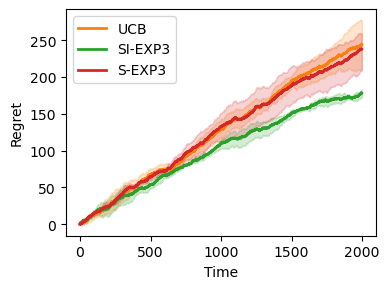

In [ ]:
sampling_rules = ["UCB","SI-EXP3","S-EXP3"]
T_plot = T
fig=plt.figure(figsize=(4,3), dpi= 100, facecolor='w', edgecolor='k')  # to have big plots
for i in range(3):
    means = np.mean(regret[i,:,:], axis=0)
    quantiles = mstats.mquantiles(regret[i,:,:], axis=0)
    plt.plot(np.arange(T_plot-1),means[1:T_plot], label=sampling_rules[i], color = colors[i+1], linewidth=2)
    plt.fill_between(np.arange(T_plot-1), quantiles[0,1:T_plot] ,quantiles[2,1:T_plot], color= colors[i+1], alpha=.2)
plt.xlabel("Time")
plt.ylabel('Regret')
plt.legend()
plt.savefig('exp4_iid_dependent.pdf', bbox_inches = "tight")
plt.show()

### Exp 5: random zero-sum game with unavailable actions for both players

In [ ]:
import nashpy as nash

sampling_rules = ["UCB","SI-EXP3","S-EXP3"]
T = 2000
K = 3
niter = 10


regret = np.zeros((3,niter,T))

for i in tqdm(range(niter)):

    n=np.zeros(K)
    z=np.zeros(K)
    L=np.zeros((K,K))

    S = np.empty((0,K), int)
    cum_loss =np.zeros(K)
    
    G = np.array([[0, -1, 1], [1, 0, -1], [-1, 1, 0]]) # rock paper scisors matrix
#     G = np.random.uniform(low=0, high=1, size=(K, K))
#     G = (np.triu(G) + np.triu(1-G).T) - np.identity(K) / 2

    M = 4
    A = np.zeros((M,K), int)
    w = np.zeros((M,K), float)

    for j in range(M):
        A[j]=np.random.binomial(n=1,p=.7,size=K)
        while sum(A[j]) < 2:
            A[j]=np.random.binomial(n=1,p=.7,size=K)

        k=sum(A[j])
        idx = np.array(np.where(A[j]>0)).reshape(k,1)
        G0 = G[idx,idx.T]
        rps = nash.Game(G0)
        w[j,idx.T] = list(rps.support_enumeration())[0][0]
    
    
    for t in range(T):
        a=np.random.randint(0,M-1)
        adv=np.random.choice(K,1,p=w[a]) # adversary plays Nash equilibrium
        loss=1-G[:,adv]
        avail=A[a]
        
        eta = 1/(t+1)**0.5
        lam = 1/np.sqrt(t+1)

        choice1, n, z = ucb(n, z, t, avail, loss)
        choice2, L = SIEXP3(L, eta, avail, loss)
        choice3, cum_loss, S = sleeping_exp3(cum_loss,S,eta,lam,avail,loss)

        regret[0,i,t] = loss[choice1] - .5
        regret[1,i,t] = loss[choice2] - .5
        regret[2,i,t] = loss[choice3] - .5
    
    for j in range(3):
        regret[j,i,:] = np.cumsum(regret[j,i,:])

100%|███████████████████████████████████████████| 10/10 [09:49<00:00, 58.97s/it]


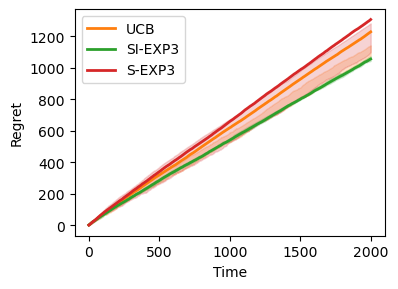

In [ ]:
sampling_rules = ["UCB","SI-EXP3","S-EXP3"]
T_plot = T
fig=plt.figure(figsize=(4,3), dpi= 100, facecolor='w', edgecolor='k')  # to have big plots
for i in range(3):
    means = np.mean(regret[i,:,:], axis=0)
    quantiles = mstats.mquantiles(regret[i,:,:], axis=0)
    plt.plot(np.arange(T_plot-1),means[1:T_plot], label=sampling_rules[i], color = colors[i+1], linewidth=2)
    plt.fill_between(np.arange(T_plot-1), quantiles[0,1:T_plot] ,quantiles[2,1:T_plot], color= colors[i+1], alpha=.2)
plt.xlabel("Time")
plt.ylabel('Regret')
plt.legend()
plt.savefig('exp5_random_zero_sum_game.pdf', bbox_inches = "tight")
plt.show()